## Filtering

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import time

_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

from functions.filtering import *
from functions.plotting import *

### Original data

In [2]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

col_to_drop = ["per_slope_change_"+str(i) for i in range(8)]+\
            ["slope_" + str(i) for i in range(9)]    
drug_curves.drop(col_to_drop, axis=1, inplace=True)    
    
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

(225384, 28)

## Filtering 1: 4 stage filtering

In [3]:
%%time
# difference between middle points 0.2
df_filt_1234 = filtering_sigmoid_curves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2, 
                         middle_points_limit = -0.2)
df_filt_1234.to_csv(_FOLDER_3+"filt_1234_02.csv", index=False)

Original dataset: (225384, 28)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 28)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 30)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 30)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2108, 30)
CPU times: user 1.1 s, sys: 199 ms, total: 1.3 s
Wall time: 1.79 s


## Bad data after filtering 1

In [4]:
high_resp_data = find_high_responses(df_filt_1234, response_norm)

if high_resp_data.shape[0]==0:
    print("No high response data")
else: 
    print("Responses above 1:", high_resp_data.shape[0])
    df = high_resp_data
    show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

No high response data


Ascending points: 71


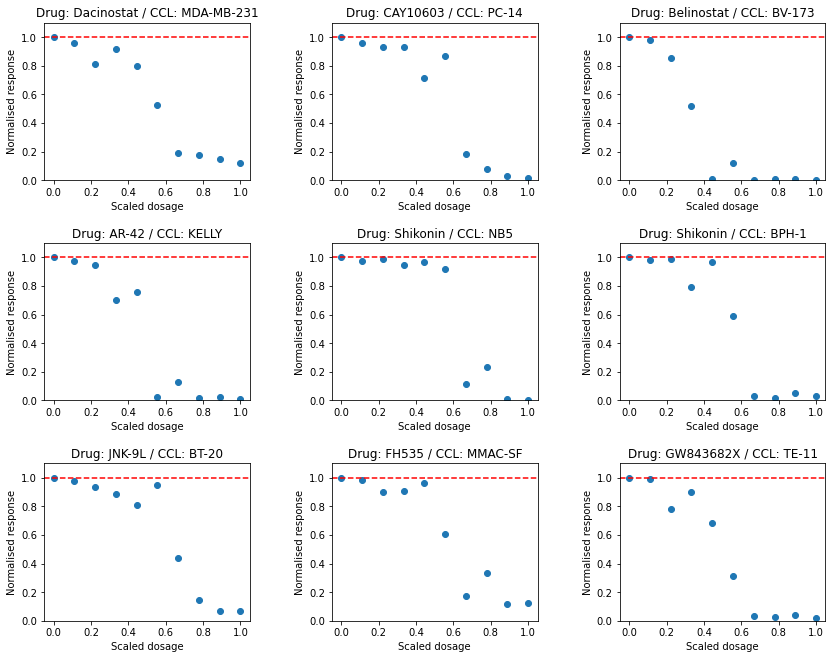

In [5]:
ascend_data = find_ascending_data(df_filt_1234, response_norm, middle_points_limit=-0.1)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Filtering 2:  auc>0.7 and spearman_r<0

In [6]:
%%time
df_filt_auc = auc_filtration(drug_curves, conc_columns, response_norm, 
                         auc_limit=0.7, final_response_limit=0.2)
df_filt_auc.to_csv(_FOLDER_3+"filt_auc_02.csv", index=False)

100%|██████████| 225384/225384 [37:52<00:00, 99.16it/s] 


CPU times: user 33min 5s, sys: 1min 26s, total: 34min 31s
Wall time: 37min 54s


In [7]:
df_filt_auc.shape

(14084, 31)

## Bad data left after filtering 2

Responses above 1: 8404


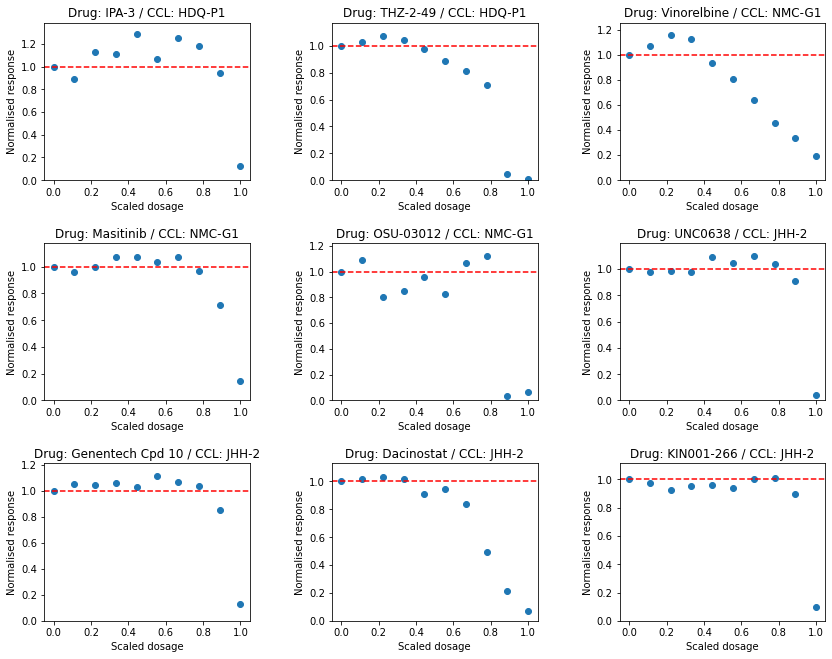

In [9]:
high_resp_data = find_high_responses(df_filt_auc, response_norm)
print("Responses above 1:", high_resp_data.shape[0])

df = high_resp_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Ascending points: 4797


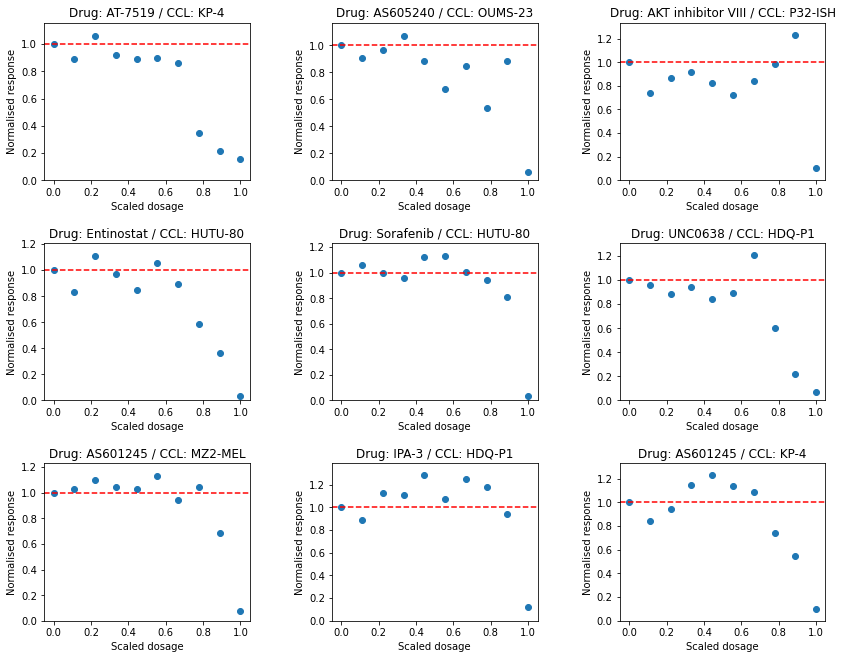

In [10]:
ascend_data = find_ascending_data(df_filt_auc, response_norm, middle_points_limit=-0.1)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Filtering 3: direct fitting

In [11]:
functions = [
             "fsigmoid", 
             "sigmoid_2_param",
             "sigmoid_3_param",
             "sigmoid_4_param",
             "logistic_4_param",
            "ll4_4_param",
            "ll4R_4_param",
            "logLogist_3_param"]

In [ ]:
%%time
df_no_filt = compare_fitting_functions(drug_curves, functions, conc_columns, response_norm, 
                                       save_file_name = _FOLDER_3 +"fit_no_filt.csv")

(225384, 28)

 fsigmoid


  9%|▉         | 20149/225384 [00:54<07:41, 444.90it/s]